## An attempt to break captcha using naive network

In [12]:
from captcha.image import ImageCaptcha
import matplotlib 
matplotlib.use('Agg') 
from matplotlib import pyplot as plt
import numpy as np
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
# import tensorflow as tf
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from keras.utils import multi_gpu_model
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [13]:
from spatial_transformer import SpatialTransformer

In [18]:
%config InlineBackend.figure_format = 'retina'

import string
# What all to include in the captcha
characters = string.digits + string.ascii_uppercase
print(characters)

#width and height of the captcha
# number of characters in captcha and number of classes captcha can take characters from
width, height, n_len, n_class = 60, 60, 2, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# Data Generator

In [19]:
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
#             print("randome_str:", random_str)
            X[i] = generator.generate_image(random_str)
            # Range of j is n_len
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

# Test Generator

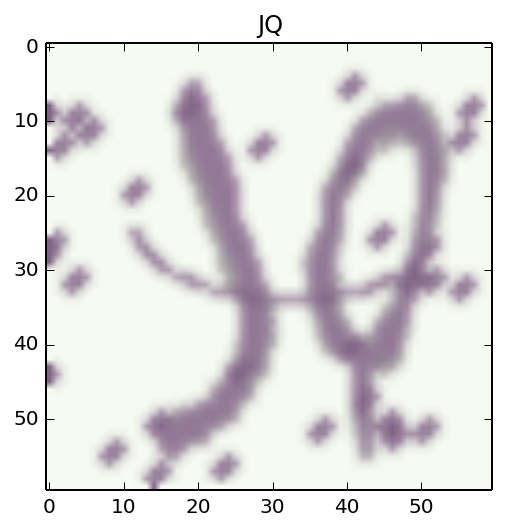

In [20]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

# Network structure

In [21]:
# initial weights for the localisation network or the finding the transformation matrix
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [22]:
input_shape = (60,60,3)
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
locnet.add(Convolution2D(20, (5, 5)))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, (5, 5)))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))
#locnet.add(Activation('sigmoid'))

In [36]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
x = SpatialTransformer(localization_net=locnet, output_size=(height, width, 3), input_shape=input_shape)(x)

for i in range(3):
    x = Conv2D(32*2**i,(3, 3), activation='relu')(x)
    x = Conv2D(32*2**i,(3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(input=input_tensor, output=x)

# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
# model = multi_gpu_model(model, gpus=4)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

/local/usr.local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


# Network structure visualization

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 60, 60, 3)    0                                            
__________________________________________________________________________________________________
spatial_transformer_7 (SpatialT (None, 60, 60, 3)    92896       input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 58, 58, 32)   896         spatial_transformer_7[0][0]      
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 56, 56, 32)   9248        conv2d_51[0][0]                  
__________________________________________________________________________________________________
max_poolin

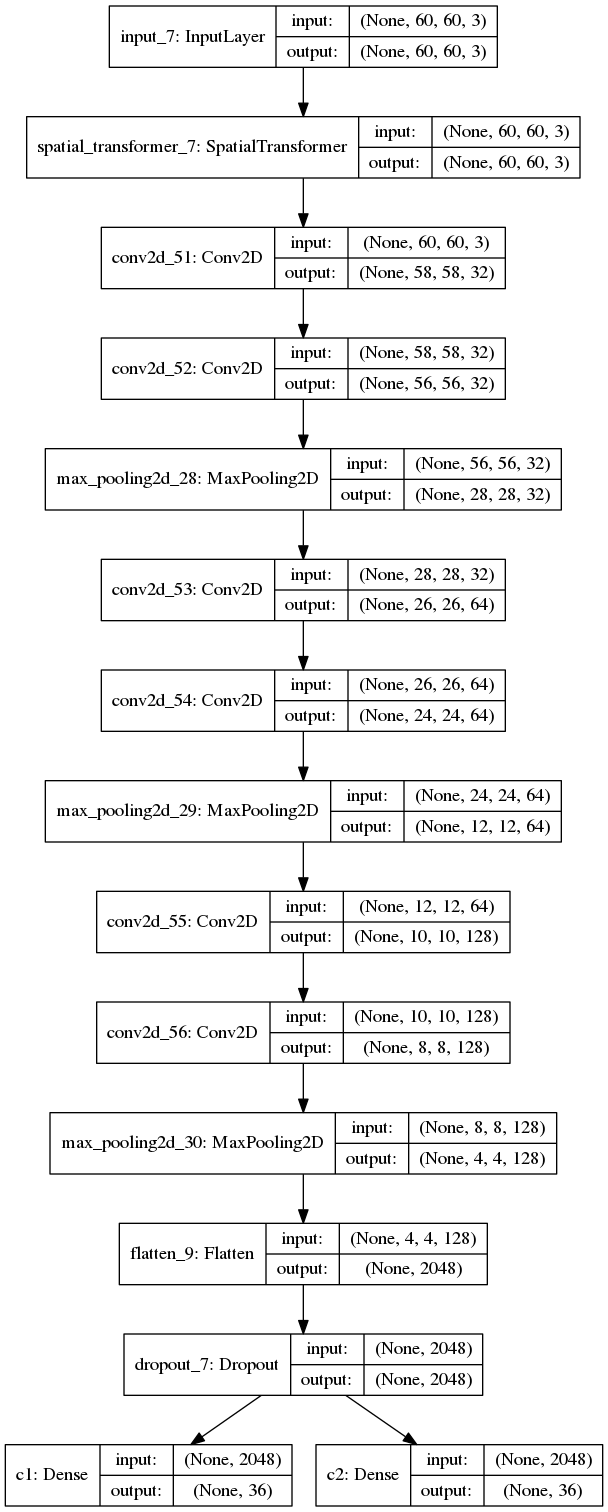

In [37]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
model.summary()

plot_model(model, to_file="model_stn.png", show_shapes=True)
Image('model_stn.png')

# Training

In [35]:
model.fit_generator(gen(64), samples_per_epoch=25600, nb_epoch=3,
                    validation_data=gen(), nb_val_samples=12800)

Epoch 1/3
  444/25600 [..............................] - ETA: 37:20 - loss: 7.1674 - c1_loss: 3.5836 - c2_loss: 3.5838 - c1_acc: 0.0272 - c2_acc: 0.0274

/local/usr.local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/local/usr.local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=25600, epochs=3, validation_steps=12800)`
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

In [ ]:
model.fit_generator(gen(64), samples_per_epoch=25600, nb_epoch=3,
                    validation_data=gen(), nb_val_samples=12800)

# Save model

In [ ]:
model.save_weights('weights_stn_cnn.h5')

# Test Model

In [ ]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# Calculate the overall model accuracy

In [2]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = generator.next()
        y_pred = model.predict(X)
        batch_acc += np.mean(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
    return batch_acc / batch_num

evaluate(model)

NameError: name 'model' is not defined